# In-depth Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import adjusted_mutual_info_score, SCORERS
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split


import datetime as dt
import seaborn as sns
# df = pd.read_csv('./data/final_NYC_crimes.csv', parse_dates=[['DATE', 'TIME']])
df = pd.read_csv('./data/final_NYC_crimes.csv')

In [2]:
df.head()

,CMPLNT_NUM,DISTRICT,BOROUGH,DATE,TIME,CRM_ATPT_CPTD_CD,OFFENSE LEVEL,PREM_TYP_DESC,OFFENSE_NAME,SUSP_AGE_GROUP,...,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,YEAR,MONTH,DAY,CRIME_TYPE
0,314773184,48,BRONX,2019-12-31,18:00:00,COMPLETED,FELONY,STREET,ROBBERY,UNKNOWN,...,F,1016990,244612,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)",2019,12,31,ROBBERY
1,289837961,25,MANHATTAN,2019-12-30,20:30:00,COMPLETED,MISDEMEANOR,RESIDENCE - APT. HOUSE,PETIT LARCENY,UNKNOWN,...,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)",2019,12,30,LARCENY
2,535744284,77,BROOKLYN,2019-12-24,16:55:00,COMPLETED,FELONY,STREET,FELONY ASSAULT,UNKNOWN,...,M,1001068,183317,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)",2019,12,24,ASSAULT
3,895678119,52,BRONX,2019-12-30,19:32:00,COMPLETED,MISDEMEANOR,CHAIN STORE,PETIT LARCENY,25-44,...,D,1009690,257590,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)",2019,12,30,LARCENY
4,299841674,18,MANHATTAN,2019-12-30,15:30:00,COMPLETED,MISDEMEANOR,STREET,PETIT LARCENY,UNKNOWN,...,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)",2019,12,30,LARCENY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450978 entries, 0 to 450977
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CMPLNT_NUM        450978 non-null  int64  
 1   DISTRICT          450978 non-null  int64  
 2   BOROUGH           450978 non-null  object 
 3   DATE              450978 non-null  object 
 4   TIME              450978 non-null  object 
 5   CRM_ATPT_CPTD_CD  450978 non-null  object 
 6   OFFENSE LEVEL     450978 non-null  object 
 7   PREM_TYP_DESC     450978 non-null  object 
 8   OFFENSE_NAME      450978 non-null  object 
 9   SUSP_AGE_GROUP    450978 non-null  object 
 10  SUSP_RACE         450978 non-null  object 
 11  SUSP_SEX          450978 non-null  object 
 12  VIC_AGE_GROUP     450978 non-null  object 
 13  VIC_RACE          450978 non-null  object 
 14  VIC_SEX           450975 non-null  object 
 15  X_COORD_CD        450978 non-null  int64  
 16  Y_COORD_CD        45

#### Preparing the variables to be used.

In [10]:
# Step 1: Select columns of interest - Primary_Type, Arrest, Domestic, Location_Description, and Community_Area. 
crime_model = df[['CRIME_TYPE', 'CRM_ATPT_CPTD_CD', 'PREM_TYP_DESC', 'BOROUGH', 'TIME', 'DATE', 'VIC_AGE_GROUP']]

# Step 2: Divide dataset into inputs (crime_x) and output variable (crime_y)
crime_x = crime_model[['PREM_TYP_DESC', 'BOROUGH', 'VIC_AGE_GROUP', 'CRM_ATPT_CPTD_CD', 'DATE', 'TIME']]
crime_y = crime_model[['CRIME_TYPE']]

# Step 3: One-hot encode categorical inputs in crime_x 
crime_x.loc[:, 'BOROUGH'] = pd.factorize(crime_x['BOROUGH'])[0].reshape(-1,1)
crime_x.loc[:, 'CRM_ATPT_CPTD_CD'] = pd.factorize(crime_x['CRM_ATPT_CPTD_CD'])[0].reshape(-1,1)
crime_x.loc[:, 'VIC_AGE_GROUP'] = pd.factorize(crime_x['VIC_AGE_GROUP'])[0].reshape(-1,1)
crime_x.loc[:, 'DATE'] = pd.factorize(crime_x['DATE'])[0].reshape(-1,1)
crime_x.loc[:, 'TIME'] = pd.factorize(crime_x['TIME'])[0].reshape(-1,1)



crime_x = pd.get_dummies(crime_x)
crime_x_col_names = list(crime_x.columns.values)

# pd.factorize(crime_y['CRIME_TYPE'])

# Step 4: Recode crime_y to convert data from categorical labels to numeric 
crime_y.loc[:, 'CRIME_TYPE_CODE'] = pd.factorize(crime_y['CRIME_TYPE'])[0].reshape(-1,1)
crime_y = crime_y[['CRIME_TYPE_CODE']]

# print('0',crime_y)

# # Step 5
crime_x = np.array(crime_x)
crime_y = np.array(crime_y)

crime_y = crime_y.reshape(-1)

crime_y

# Step 6
# sss = StratifiedShuffleSplit(n_splits=3, test_size=0.20, random_state=0)
# sss.get_n_splits(crime_x, crime_y)


# for train_index, test_index in sss.split(crime_x, crime_y):
#     print("TRAIN:", len(train_index), train_index, "TEST:", len(test_index),test_index)
#     X_train, X_test = crime_x[train_index], crime_x[test_index]
#     y_train, y_test = crime_y[train_index], crime_y[test_index]

# Step 6 using train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(crime_x, crime_y, train_size=0.8)



In [11]:
Xtrain[2]

array([ 3,  0,  0, 27, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

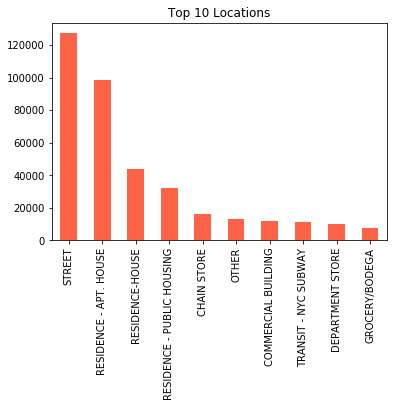

In [12]:
# Plot The top 10 crimes

crime_df10 = crime_model.CRIME_TYPE.value_counts().head(10)

crime_df10 = pd.DataFrame(crime_df10)

crime_df10 = crime_model.PREM_TYP_DESC.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Locations")
plt1.get_legend().remove()


#### Resampling method for multiclass data
Since we have skewed data, we want to resample data to make it balanced. 
The data is skewed somehow

In [13]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

# Using imblearn resampling methods from:
# https://heartbeat.fritz.ai/resampling-to-properly-handle-imbalanced-datasets-in-machine-learning-64d82c16ceaa

from imblearn.under_sampling import RandomUnderSampler

# create the object.
under_sampler = RandomUnderSampler()

# Undersampling: fit the object to the training data.
x_train_under, y_train_under = under_sampler.fit_sample(Xtrain, ytrain)


/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in versi

#### Initiating logistic regression.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=1000)
# Fit the model on the trainng data.
clf.fit(x_train_under, y_train_under)
# Print the accuracy from the testing data.
score = (accuracy_score(clf.predict(Xtest), ytest))
print(score)

0.1614262273271542


/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Confusion matrix

In [15]:
clf.predict(Xtest)
predictions = clf.predict(Xtest)

In [16]:
from sklearn import metrics
cm = metrics.confusion_matrix(ytest, predictions)

print(cm)

[[  75  218   75  100  189    0   93  182  907    9  104   11  136   16
   160  113   88   15   64  152]
 [ 114 6889  730 1973 2579    7 1616  890 5182   75  280  185  299  219
  1386  639  995  342  783 1593]
 [ 105  987  719  847 2574    2 1472  642 2972   30  250   66  154  130
  1616  473  499  196  415  598]
 [   5  102   24  352  180    0   95   76   99    3   25    5   46    6
    61   98   16   20  100  181]
 [  32 1266  654  969 3183    1 1711  375 1843   14  156  104   33  188
  1942  312  418  211  390  471]
 [   7   67   26  253  348    0  170  506   32   13  132    8   50    4
   115  131   38   56   80   73]
 [   2  123   59  389  518    0  505   97   62    9   34    9  115    7
   230   34  101   68  257  199]
 [   0    2    0   11    0    0    2  589   49   12  114    2    2    1
     7    0   13   13    5   28]
 [  15   32   27   10    1    0    1  224  820    9  130    0    1   10
    30    4   10    8   12   16]
 [  12   24   18  168   38    0   96  425  151   24  16

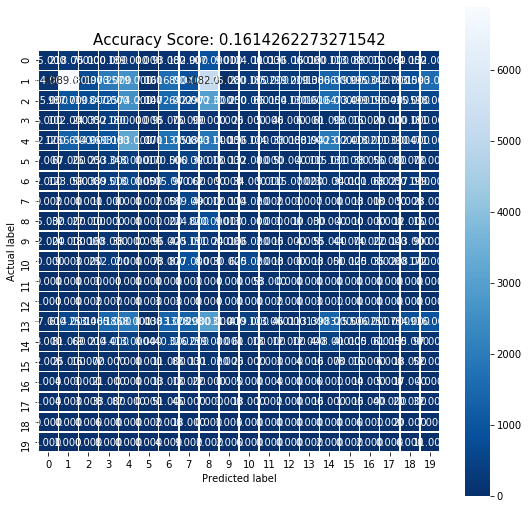

In [17]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [18]:
# Plot The top 10 crimes

crime_df10 = crime_model.CRIME_TYPE.value_counts().head(10)

crime_df10 = pd.DataFrame(crime_df10)

# plt1 = crime_df10.plot(kind="bar", color = "tomato")
# plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
# plt1.set_title("Top 10 Crimes")
# plt1.get_legend().remove()

crime_df10

,CRIME_TYPE
LARCENY,134122
OFFENSES_AGAINST_PUBLIC_ORDER,74031
ASSAULT,73102
HARRASSMENT,71000
MISC_PENAL_LAW,14048
BURGLARY,13973
POSSESSION_CONTROLLED_SUBSSTANCE,13367
ROBBERY,13325
FRAUD,10876
POSSESSION_WEAPON,7791


In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

#### View ROC Curve : This  will be used for scoring our model

In [20]:
# View ROC Curve : This  will be used for scoring the 
def ez_roc(model, x, y, pos_label=1):
    """prints a basic Receivor Operator Curve (ROC). 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    pos_label --binary label considered positive in y  (dtype='int', default=1)
    """
    from sklearn.metrics import roc_curve, auc

    model_name=type(model).__name__ # defining model name as the __name__ characteristic held by sklearn models

    y_proba = model.predict_proba(x)[:,1]
        
    fpr, tpr, thresholds = roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC curve')
    ax1= plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.3f' % (model_name, roc_auc), linewidth=2)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return()

#### Random Forest¶
This function includes parameters for stratified cross-fold validation and supports code for hyperparameter tuning for a random forest model. Because we are working with a multi-classification problem, we evaluate our logistic regression models with one-vs-one classification.

In [21]:
def hypertuning_fxn(X, y, nfolds, model , param_grid, scoring = 'roc_auc_ovo_weighted', verbose=True, cv = True, 
                    return_train_score = True): 
    
    """function that uses GridSearchCV to test a specified param_grid of hyperparameters and choose the optimal one based on nfolds cross-validation results. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    X -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints a the roc_auc score from 10-fold crossvalidation (dtype='boolean', default='True')
    """
    
    np.random.seed(12345)
    
    # The scorers can be either be one of the predefined metric strings or a scorer
    # callable, like the one returned by make_scorer
#     scoring = {'AUC': 'roc_auc_ovr', 'Accuracy': make_scorer(accuracy_score)}

    grid_search = GridSearchCV(estimator= model,
                                     param_grid=param_grid,
                                     cv=KFold(nfolds), # stratified k-folds will preserve class balances - this function is what got the rest of the code to work with roc validation
                                     scoring=scoring,
                                     return_train_score=True,
                                     n_jobs = -1)
    
#     scoring = {'accuracy': 'accuracy', 'auc': 'roc_auc_ovr'}
#     scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

    grid_search.fit(X, y)
    print(" scorer function: {}".format(scoring))
    print(" ##### CV performance: mean & sd scores #####")

    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    print('best cv score: {:0.3f}'.format(grid_search.best_score_))
    print('best cv params: ', grid_search.best_params_)

    worst_index=np.argmin(grid_search.cv_results_['mean_test_score'])
    print('worst cv score: {:0.3f}'.format(grid_search.cv_results_['mean_test_score'][worst_index]))
    print('worst cv params: ', grid_search.cv_results_['params'][worst_index])
    ##
    if verbose==True:
        for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
    
    return(grid_search)
#     print(grid_search.cv_results_)

In [22]:
# Random Forest


# Number of trees in random forest
n_estimators = [100]
# Number of features to consider at every split
max_features = ['auto'] # 'auto' which is equivalent to sqrt(n_features)
# Maximum number of levels in tree
max_depth = [5, 10]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

t1 = time.time()

model = RandomForestClassifier(criterion='entropy', random_state=12345)

In [24]:
rf_hyper = hypertuning_fxn(Xtrain, ytrain, nfolds = 5, model = model , param_grid = param_grid, scoring='roc_auc_ovo_weighted', cv = True, return_train_score = True)

t2 = time.time()  

run_time = t1 - t2
print('Training Time in Minutes:', run_time/60)

 scorer function: roc_auc_ovo_weighted
 ##### CV performance: mean & sd scores #####
best cv score: 0.789
best cv params:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
worst cv score: 0.764
worst cv params:  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.765 (+/-0.003) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.764 (+/-0.003) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.764 (+/-0.003) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
0.765 (+/-0.003) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
0.765 (+/-0.003) for {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_sampl

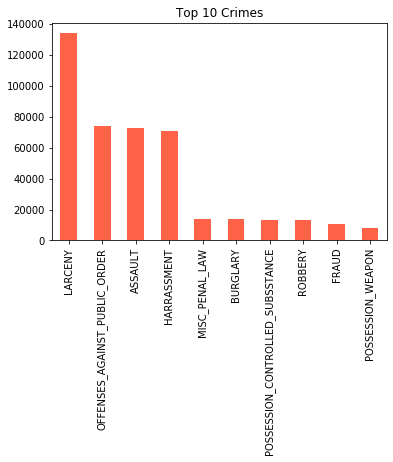

In [25]:
crime_df10 = crime_model.CRIME_TYPE.value_counts()
crime_df10 = crime_df10.head(10)

crime_df10 = pd.DataFrame(crime_df10)

plt1 = crime_df10.plot(kind="bar", color = "tomato")
plt1.tick_params(axis="x", labelsize = 10, labelrotation = 90)
plt1.set_title("Top 10 Crimes")
plt1.get_legend().remove()


In [26]:
print(rf_hyper.best_estimator_)
rf = rf_hyper.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=10,
                       random_state=12345)


In [27]:

def evaluate_model(model, x, y, cv = True):
    """prints common binary classification evaluation metrics and an ROC curve. 

    Keyword arguments:
    model -- a 'fitted' sklearn model object 
    x -- predictor matrix (dtype='numpy array', required)
    y -- outcome vector (dtype='numpy array', required)
    cv -- if True, prints  score from 5-fold crossvalidation (dtype='boolean', default='True')
    """
    import sklearn.metrics
    from sklearn.metrics import log_loss, average_precision_score, precision_recall_curve
    from sklearn.model_selection import cross_val_score


    if cv==True:
        cv_results= cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=Kfold(5))
        print("across 5 fold cv on trainingset, the model had \n", 
             "mean auroc: {:0.3f}".format(np.mean(cv_results)), "\n",
             "std auroc: {:0.3f}".format(np.std(cv_results))
             )

        base_cv_score=np.mean(cross_val_score(model, x, y, scoring='roc_auc_ovo_weighted', cv=Kfold(5)))

    print("###metrics on provided dataset:###")
    
    ##basic model performance
    y_hat = model.predict(x) # predicted classes using default 0.5 threshold
    y_proba = model.predict_proba(x)[:,] #predicted probabilities
    auc=roc_auc_score(y, y_proba, multi_class = 'ovr', average = 'weighted')

    print ('the AUC is: {:0.3f}'.format(auc))
    
    # Modify labels for the classification reports
    crime_labels = list(range(0,11))
    crime_labels = np.asarray(crime_labels)
    
#     crime_names = df.CRIME_TYPE.tolist().drop_duplicates()
    
    print("classification report:\n ", classification_report(y, y_hat, labels = crime_labels, target_names = df['CRIME_TYPE'], digits=3))

    #ez_roc(model, x, y, pos_label = 1) #plotting roc curve
    #plt.show()

In [28]:
# Evaluating Training Data

evaluate_model(rf_hyper.best_estimator_, Xtrain, ytrain, cv=False)

###metrics on provided dataset:###
the AUC is: 0.760


/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1947: UserWarning: labels size, 11, does not match size of target_names, 450978
  .format(len(labels), len(target_names))
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification report:
                                    precision    recall  f1-score   support

                         ROBBERY      0.610     0.043     0.080     10618
                         LARCENY      0.375     0.890     0.528    107346
                         ASSAULT      0.334     0.246     0.283     58355
                         LARCENY      0.805     0.005     0.011      6041
                         LARCENY      0.305     0.163     0.212     56727
                         LARCENY      0.000     0.000     0.000      8767
                         ASSAULT      0.696     0.001     0.003     11155
                         ROBBERY      0.552     0.015     0.029      3516
                      SEX_CRIMES      0.883     0.017     0.033      5380
                     HARRASSMENT      0.000     0.000     0.000      6220
                     HARRASSMENT      0.339     0.264     0.297     10764

                       micro avg      0.364     0.430     0.394    284889
           

In [29]:
# Evaluating Testing Data

evaluate_model(rf_hyper.best_estimator_, Xtest, ytest, cv = False)

###metrics on provided dataset:###
the AUC is: 0.749
classification report:
                                    precision    recall  f1-score   support

                         ROBBERY      0.542     0.035     0.067      2707
                         LARCENY      0.372     0.888     0.525     26776
                         ASSAULT      0.327     0.233     0.272     14747
                         LARCENY      0.000     0.000     0.000      1494
                         LARCENY      0.300     0.159     0.208     14273
                         LARCENY      0.000     0.000     0.000      2109
                         ASSAULT      0.000     0.000     0.000      2818
                         ROBBERY      0.545     0.014     0.028       850
                      SEX_CRIMES      0.700     0.010     0.020      1360
                     HARRASSMENT      0.000     0.000     0.000      1571
                     HARRASSMENT      0.325     0.258     0.287      2603

                       micro avg

/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1947: UserWarning: labels size, 11, does not match size of target_names, 450978
  .format(len(labels), len(target_names))
/Users/bea/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
crime10 = list(crime_df10.index.values)
crime10

['LARCENY',
 'OFFENSES_AGAINST_PUBLIC_ORDER',
 'ASSAULT',
 'HARRASSMENT',
 'MISC_PENAL_LAW',
 'BURGLARY',
 'POSSESSION_CONTROLLED_SUBSSTANCE',
 'ROBBERY',
 'FRAUD',
 'POSSESSION_WEAPON']

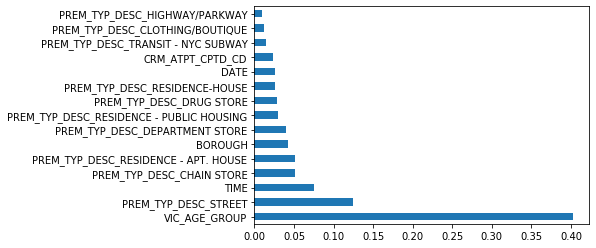

In [32]:
# create empty list
feat_impts = []

# bind all rf estimators for each classifier 
for model in rf_hyper.best_estimator_:
    feat_impts.append(model.feature_importances_)

# calculate the mean of features across predictors
feat = np.mean(feat_impts, axis=0)
# create a list of features (predictor names)
features = crime_x_col_names
# add predictor names to the means
feat_importances = pd.Series(feat, index = features)   

# plot feature importance for nlargest means 
feat_importances.nlargest(15).plot(kind='barh')